Initial production rate: 35180.562 MCF/day
Initial decline rate: 0.002 MCF/day
Decline coefficient: 0.231


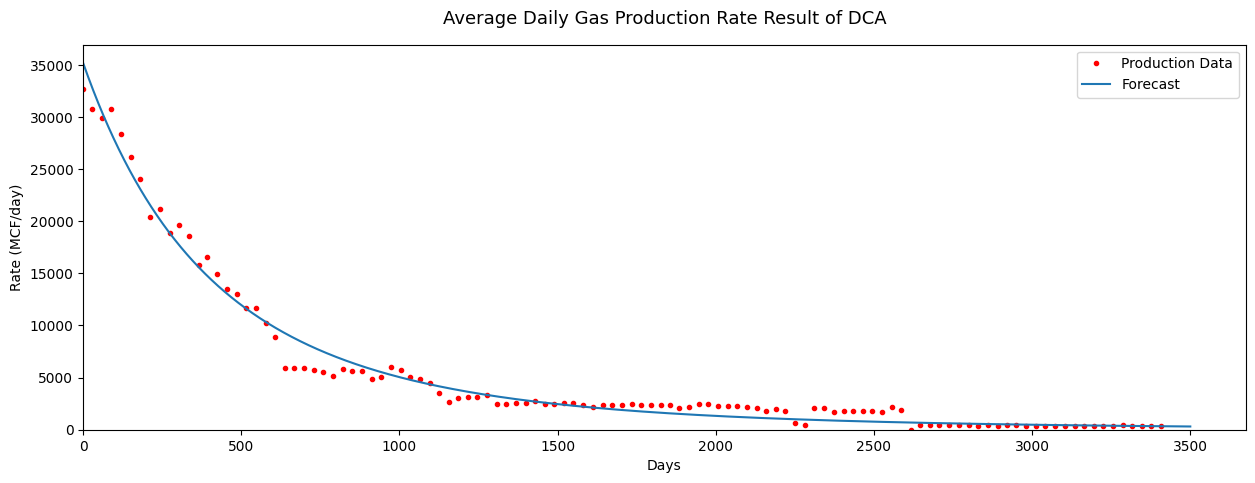

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime

# Fit the data with a hyperbolic function
from scipy.optimize import curve_fit

# Create a shortcut to the csv file with production data
filepath1 = './513st_edited.csv'

# Load the data in
df = pd.read_csv(filepath1)

# Convert the date string in the csv file to Panda datetime format
df['Date'] =  pd.to_datetime(df['Date'], format='%Y-%m-%d')

# Creates lists for each column
t = df['Date']
q = df['Rate (MCF/d)']

# Generate array of times between production rate reports
timedelta = [j-i for i, j in zip(t[:-1], t[1:])]
timedelta = np.array(timedelta)
timedelta = timedelta / datetime.timedelta(days=1)

# Generate array of cumulative time at which production reports come in
t = np.cumsum(timedelta)
t = np.append(0, t)
t = t.astype(float)

# Normalize the time and rate data according to the max time and rate
t_normalized = t / max(t)
q_normalized = q / max(q)

# Initialize the function for hyperbolic decline
def hyperbolic(t, qi, di, b):
  return qi / (np.abs((1 + b * di * t))**(1/b))

# Find a curve that best fits the scatterplot data
popt, pcov = curve_fit(hyperbolic, t_normalized, q_normalized)

# Identify the exact parameter values of this curve
qi, di, b = popt

# De-normalize qi and di
qi = qi * max(q)
di = di / max(t)

# Print the parameter values
# Will prove helpful in finding NPV
print('Initial production rate:', np.round(qi, 3), 'MCF/day')
print('Initial decline rate:', np.round(di, 3), 'MCF/day')
print('Decline coefficient:', np.round(b, 3))

# Create a function for hyperbolic cumulative production
def cumpro(q_forecast, qi, di, b):
  return ((qi**b) / ((1 - b) * di)) * ((qi ** (1 - b)) - (q_forecast ** (1 - b)))

# Forecast gas rate until n days
n = 3500
t_forecast = np.arange(n + 1)
q_forecast = hyperbolic(t_forecast, qi, di, b)

# Forecast cumulative production until n days
Qp_forecast = cumpro(q_forecast, qi, di, b)

# Plot the production data with the forecasts (rate and cumulative production)
plt.figure(figsize=(15,5))

# Exact curve-fitting representation
plt.plot(t, q, '.', color='red', label='Production Data')
plt.plot(t_forecast, q_forecast, label='Forecast')
plt.title('Average Daily Gas Production Rate Result of DCA', size=13, pad=15)
plt.xlabel('Days')
plt.ylabel('Rate (MCF/day)')
plt.xlim(xmin=0); plt.ylim(ymin=0)
plt.legend()
plt.show()

For a hyperbolic Fit:
Initial production rate: 25115.918 MCF/day
Initial decline rate: 0.001 MCF/day
Decline coefficient: -0.368


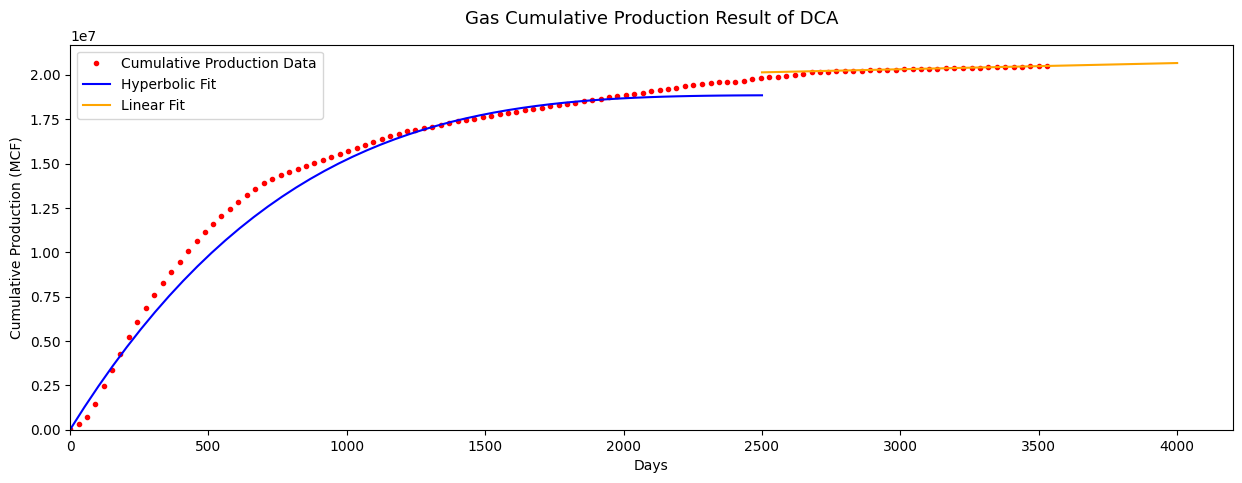

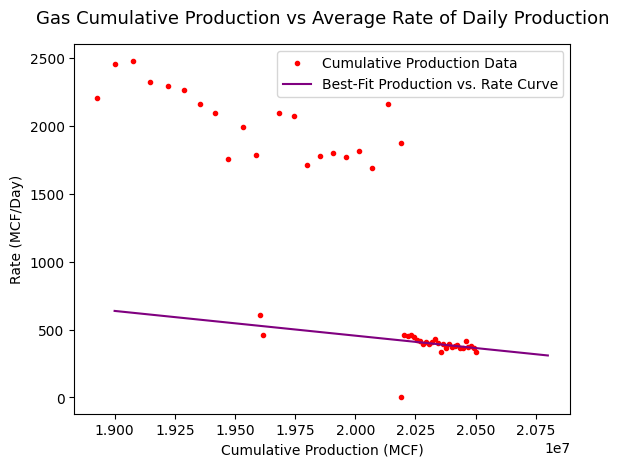

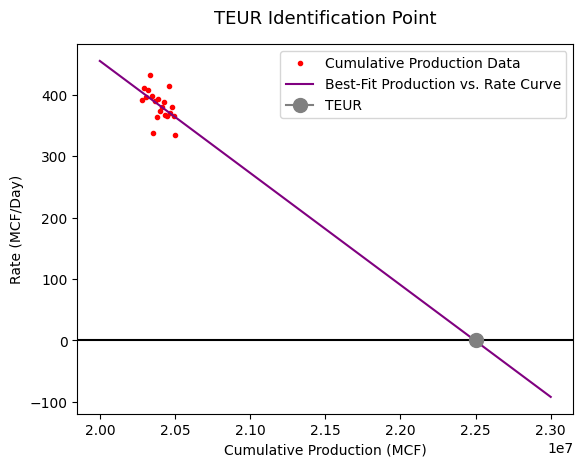

TEUR: 22496020.59
TEUR Day: 9225.0
TEUR Date: 2048-09-01 00:00:00


In [ ]:
# Create a shortcut to the new csv file with production data
filepath2 = './513st.csv'

# Load the data in
df2 = pd.read_csv(filepath2)

# Convert the date string in the csv file to Panda datetime format
df2['Date'] =  pd.to_datetime(df2['Date'], format='%Y-%m-%d')

# Creates lists for each column
t2 = df2['Date']
q2 = df2['Rate (MCF/d)']
all = df2['Production (MCF)']

# Creative cumulative scatterplot
size = len(all)
Q_cum = np.zeros(size)
for j in range(size):
  Q_cum[j] = all[j] + Q_cum[j - 1]

# Generate array of times between production rate reports
timedelta2 = [j-i for i, j in zip(t2[:-1], t2[1:])]
timedelta2 = np.array(timedelta2)
timedelta2 = timedelta2 / datetime.timedelta(days=1)

# Generate array of cumulative time at which production reports come in
t2 = np.cumsum(timedelta2)
t2 = np.append(0, t2)
t2 = t2.astype(float)

# Normalize the time and rate data according to the max time and rate
t2_normalized = t2 / max(t2)
q2_normalized = q2 / max(q2)

# Define a basic linear function
def linear(t2, m2, intercept2):
  return m2 * t2 + intercept2

# Find curves that best fits the scatterplot data
popt2, pcov2 = curve_fit(hyperbolic, t2_normalized, q2_normalized)

# Identify the exact parameter values these curves
qi2, di2, b2 = popt2

# De-normalize qi and di and Q_cum
qi2 = qi2 * max(q2)
di2 = di2 / max(t2)

# Print the parameter values
# Will prove helpful in finding NPV
print('For a hyperbolic Fit:')
print('Initial production rate:', np.round(qi2, 3), 'MCF/day')
print('Initial decline rate:', np.round(di2, 3), 'MCF/day')
print('Decline coefficient:', np.round(b2, 3))

# Create a function for hyperbolic cumulative production
def cumpro2(q2_forecast, qi2, di2, b2):
  return ((qi2 ** b2) / ((1 - b2) * di2)) * ((qi2 ** (1 - b2)) - (q2_forecast ** (1 - b2)))

# Forecast gas rate until n2 days
n2_firststop = 2500
first_interval = np.linspace(1, n2_firststop)
hyp_forecast = hyperbolic(first_interval, qi2, di2, b2)
# Forecast cumulative production until n2 days
cumprod1_forecast = cumpro2(hyp_forecast, qi2, di2, b2)
# Second forecast interval
n2_secondstop = 4000
second_interval = np.linspace(n2_firststop, n2_secondstop)
hyp2_forecast = hyperbolic(second_interval, qi2, di2, b2)
# Model Second forecast
cumprod2_forecast = cumpro2(hyp2_forecast, qi2, di2, b2)

# Fit the linear curve to a line in order to determine TEUR
eur_d, eurcov_d = curve_fit(linear, t2[-20:], Q_cum[-20:])
m_d, intercept_d = eur_d

# Fit the linear curve to a line in order to determine TEUR
eur_a, eurcov_a = curve_fit(linear, cumprod1_forecast, hyp_forecast)
m_a, intercept_a = eur_a
eur_b, eurcovb = curve_fit(linear, cumprod2_forecast, hyp2_forecast)
m_b, intercept_b = eur_b

# Restrict domain and range and repeat curve fitting
eur_c, eurcovc = curve_fit(linear, Q_cum[-20:], q2[-20:])
m_c, intercept_c = eur_c
newtimeline = np.linspace(19000000, 20800000, 10000)
theoreticaltimeline = np.linspace(20000000, 23000000, 10000)

# Fit the linear curve to a line in order to determine TEUR
eur_d, eurcov_d = curve_fit(linear, t2[-3:], Q_cum[-3:])
m_d, intercept_d = eur_d

# Plot the production data with the forecasts (rate and cumulative production)
plt.figure(figsize=(15,5))

# Cumulative gas production growth
plt.plot(t2, Q_cum, '.', color='red', label='Cumulative Production Data')
plt.plot(first_interval, cumprod1_forecast, color='blue', label = 'Hyperbolic Fit')
plt.plot(second_interval, m_d * second_interval + intercept_d, color='orange', label = 'Linear Fit')
plt.title('Gas Cumulative Production Result of DCA', size=13, pad=15)
plt.xlabel('Days')
plt.ylabel('Cumulative Production (MCF)')
plt.xlim(xmin=0); plt.ylim(ymin=0)

plt.legend()
plt.show()

# The higher the cumulative production, the lower the rate (Negative correlation)
plt.plot(Q_cum[-50:], q2[-50:], '.', color='red', label='Cumulative Production Data')
plt.plot(newtimeline, m_c * newtimeline + intercept_c, linestyle='solid', color = 'purple', label = 'Best-Fit Production vs. Rate Curve')
plt.title('Gas Cumulative Production vs Average Rate of Daily Production', size=13, pad=15)
plt.xlabel('Cumulative Production (MCF)')
plt.ylabel('Rate (MCF/Day)')
plt.legend()
plt.show()

# The higher the cumulative production, the lower the rate (Negative correlation)
plt.plot(Q_cum[-20:], q2[-20:], '.', color='red', label='Cumulative Production Data')
plt.plot(theoreticaltimeline, m_c * theoreticaltimeline + intercept_c, linestyle='solid', color = 'purple', label = 'Best-Fit Production vs. Rate Curve')
plt.title('TEUR Identification Point', size=13, pad=15)
plt.xlabel('Cumulative Production (MCF)')
plt.axhline(y = 0, color = 'black', linestyle = '-')
plt.plot(22500000, 0, marker="o", markersize=10, color = 'grey', label = 'TEUR')
plt.ylabel('Rate (MCF/Day)')
plt.legend()
plt.show()

from datetime import date, datetime, timedelta
# Last dates of actual results and price data
last_actual = datetime(2023, 5, 31)
last_pricedata = datetime(2027, 12, 31)

# Find TEUR Point
TEUR_x = -intercept_c / m_c
print('TEUR: ' + str(TEUR_x.round(2)))

# Find TEUR day based off linear projection
TEUR_daynumber = ((TEUR_x - intercept_d) / m_d).round()
TEUR_date = last_actual + timedelta(TEUR_daynumber)
print('TEUR Day: ' + str(TEUR_daynumber.round()))
print('TEUR Date: ' + str(TEUR_date))


In [ ]:
# CENTRAL DATA FOR MODEL

# Calculate the number of days between two dates
def number_of_days(date_1, date_2):
    return (date_2 - date_1).days

# Number of days between the last day of data and the final date of price data
pricinginterval = number_of_days(last_actual, last_pricedata)

# Find number of the last date of actual data
lastday = round(t[len(t)-1])

# Find date of last forecasted day
finaldate = last_actual + timedelta(n)

# Find number of months within forecast (05/31/23)
months = (finaldate.year - last_actual.year) * 12 + (finaldate.month - last_actual.month)

# Set the length of the forecast
# 4574 pulled from max_profit day
n = 4574 - lastday

# Define the discount rate and its inverse
discountrate = 0.1
inv_discountrate = 1 - discountrate

# MCF to MMBtu Conversion Factor (Describes Oil Quality)
conversion_factor = 1.225

# Price Estimates (Email from Blaine -> Wells Fargo Commodities; NG NYMEX Swap [$/MMbtu])
price23 = 3.209
price24 = 3.618
price25 = 4.003
price26 = 4.018
price27 = 3.942

# Fees (Discussed with Blaine)
fixed_monthly_cost = 7500 # $/w/mon
gas_processing_expense = 0.35 # $ / MCF [gross volume]
var_gas = 0.25 # $ / MCF [gross volume]
abandonment_fee = 150000 # $/w

# Taxes, Royalties, Permits and More
tx_royalty = 0.25 # [gross volume - shrink] * $/mmBTU -> Source: Blaine
# regulatory_fee_9kft = 750 # $/w -> Source: https://rrcsearch3.neubus.com/esd3-rrc/index.php?profile=17&search=%7B%22item%22%3A%5B%7B%22key%22%3A%22api_ft%22%2C%22value%22%3A%2226131564%22%7D%5D%7D
tx_severance_tax = 0.075 # %$ -> Source: https://www.rrc.texas.gov/oil-and-gas/publications-and-notices/texas-severance-tax-incentives/#:~:text=The%20baseline%20Texas%20severance%20tax,market%20value%20of%20oil%20produced
kenedy_adv_tax = 0.005563760 # %$ -> Source: chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://www.co.kenedy.tx.us/upload/page/4736/2022/Kenedy%20County%202023%20Adopted%20Budget%2009162022.pdf
total_MCF_fee_deductability_percentage = 0

# Differentials (Discussed with Blaine)
gas_diff = 0.1 # +/-%$

# Production Assumptions
shrink_gas = .025
shrink_oil = .05

In [ ]:
# Generate an array of hyperbolic estimates for future days in MCF
estimates = np.array([hyperbolic(lastday + (j + 1), qi, di, b) for j in range(n)])

# Convert estimates to MMBtu
converted_estimates = conversion_factor * estimates

# Initialize the price array
prices = [price23, price24, price25, price26, price27]

# Initialize daily revenue arrays (not discounted and discounted)
dailyrevenue_nond = np.zeros(n)
dailyrevenue_d = np.zeros(n)
dr_high = np.zeros(n)
dr_low = np.zeros(n)

# Pre-Shrink (Gross)
# Calculate daily revenue for each day based on remaining days and price intervals
for i in range(n):
  if i < pricinginterval:
    index = (last_actual + timedelta(i)).year - last_actual.year
  else:
    index = len(prices) - 1
  dailyrevenue_nond[i] = converted_estimates[i] * prices[index]
  dailyrevenue_d[i] = (inv_discountrate ** index) * (converted_estimates[i] * prices[index])
  dr_high[i] = dailyrevenue_d[i] * (1 + gas_diff)
  dr_low[i] = dailyrevenue_d[i] * (1 - gas_diff)

# Total discounted and non-discounted revenue
total_rev_nond = np.sum(dailyrevenue_nond)
total_rev_d = np.sum(dailyrevenue_d)

# Calculate the net present value by summing up daily revenue
npv = np.sum(dailyrevenue_d).round(2)

# NPV post-differentials
npv_highside = npv * (1 + gas_diff)
npv_lowside = npv * (1 - gas_diff)

print('PRE-FEES:')
print(f'Discount Rate: {100 * discountrate:.2f}%')
print(f'Net Present Value (Projected): ${npv:.2f}')
print(f'Net Present Value (High-side): ${npv_highside:.2f}')
print(f'Net Present Value (Low-side): ${npv_lowside:.2f}')

PRE-FEES:
Discount Rate: 10.00%
Net Present Value (Projected): $1003304.57
Net Present Value (High-side): $1103635.03
Net Present Value (Low-side): $902974.11


In [ ]:
# Calculate the total royalties fee (DO WE DISCOUNT OR NOT?, GROSS OR NET?)
# Associative property of multiplication used (royalty % could have been multiplied against volume)
# TAX - DEDUCTIBLE
total_royalties_payment = (total_rev_nond * tx_royalty)

# Calculate and sum all fees that are dependent upon gross volume in MCF
# TAX - DEDUCTIBLE
MCF_fees = (var_gas + gas_processing_expense) * estimates * (1 - total_MCF_fee_deductability_percentage)
total_MCF_fees = np.sum(MCF_fees)

# Calculate total fixed monthly fees
total_monthly_fc = fixed_monthly_cost * months

# Calculate other tax fees
# Reduce taxes by royalties AND total MCF fees (which can be written off)
other_tax_fees = (total_rev_nond - total_royalties_payment - total_MCF_fees) * (tx_severance_tax + kenedy_adv_tax)

# Find profit from last data point date to sale of well
# REMOVED permit fee
profit = (npv * (1 - shrink_gas)) - total_MCF_fees - total_monthly_fc - total_royalties_payment - other_tax_fees - abandonment_fee
profit_highside = (npv_highside * (1 - shrink_gas)) - total_MCF_fees - total_monthly_fc - total_royalties_payment - other_tax_fees - abandonment_fee
profit_lowside = (npv_lowside * (1 - shrink_gas)) - total_MCF_fees - total_monthly_fc - total_royalties_payment - other_tax_fees - abandonment_fee

# Print the results
print('Projected Total Profit over ' + str(months) + ' months: $' + str(profit.round(2)))
print('Profit (Best-Case Differential Scenario): $' + str(profit_highside.round(2)))
print('Profit (Worst-Case Differential Scenario): $' + str(profit_lowside.round(2)))


Projected Total Profit over 115 months: $-532578.89
Profit (Best-Case Differential Scenario): $-434756.69
Profit (Worst-Case Differential Scenario): $-630401.08


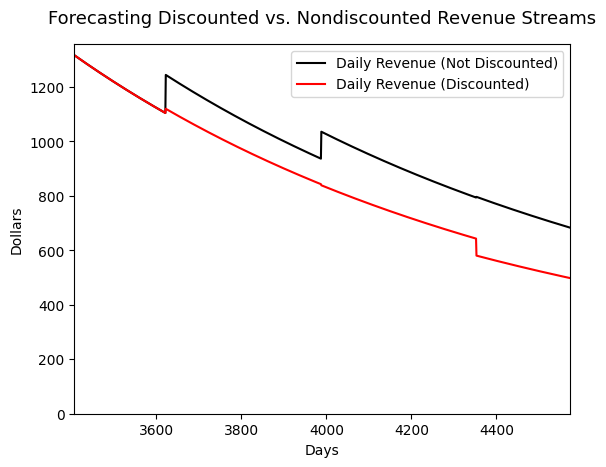

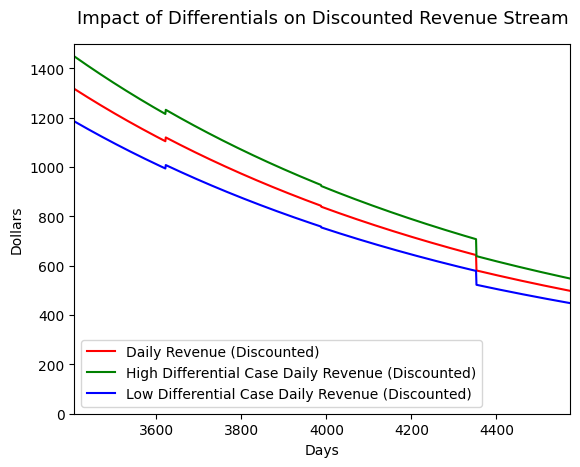

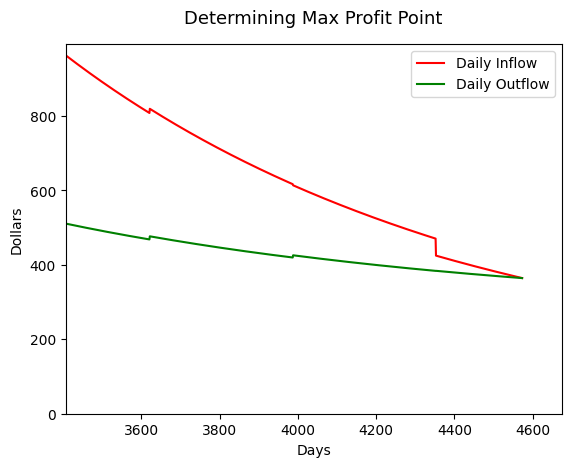

Profit Max Day: 4574
Profit Max Date: 2026-08-10 00:00:00


In [ ]:
# Determine time-scale
timescale = np.arange(lastday, n + lastday)

# Discounted vs. Nondiscounted Revenue Streams
plt.plot(timescale, dailyrevenue_nond, color='black', label='Daily Revenue (Not Discounted)')
plt.plot(timescale, dailyrevenue_d, color='red', label='Daily Revenue (Discounted)')
plt.title('Forecasting Discounted vs. Nondiscounted Revenue Streams', size=13, pad=15)
plt.xlabel('Days')
plt.ylabel('Dollars')
plt.xlim(lastday, lastday + n)  # Set x-axis limits
plt.ylim(0)
plt.legend()
plt.show()

# Differentials
plt.plot(timescale, dailyrevenue_d, color='red', label='Daily Revenue (Discounted)')
plt.plot(timescale, dr_high, color='green', label='High Differential Case Daily Revenue (Discounted)')
plt.plot(timescale, dr_low, color='blue', label='Low Differential Case Daily Revenue (Discounted)')
plt.title('Impact of Differentials on Discounted Revenue Stream', size=13, pad=15)
plt.xlabel('Days')
plt.ylabel('Dollars')
plt.xlim(lastday, lastday + n)  # Set x-axis limits
plt.ylim(0)
plt.legend()
plt.show()

# Money-in vs. Money out
inflow = dailyrevenue_d * (1 - tx_royalty) * (1 - shrink_gas)
outflow = MCF_fees + ((dailyrevenue_nond * (1 - tx_royalty) - MCF_fees) * (tx_severance_tax + kenedy_adv_tax)) + (fixed_monthly_cost / 30.44)
plt.plot(timescale, inflow, color='red', label='Daily Inflow')
plt.plot(timescale, outflow, color='green', label='Daily Outflow')
plt.title('Determining Max Profit Point', size=13, pad=15)
plt.xlabel('Days')
plt.ylabel('Dollars')
plt.xlim(lastday, lastday + n + 100)  # Set x-axis limits
plt.ylim(0)
plt.legend()
plt.show()

# Calculate profit max date
days_to_profit_maximization = 0

# Inflow/Outflow
for i in range(n):
  inflow = dailyrevenue_d[i] * (1 - tx_royalty) * (1 - shrink_gas)
  outflow = MCF_fees[i] + ((dailyrevenue_nond[i] * (1 - tx_royalty) - MCF_fees[i]) * (tx_severance_tax + kenedy_adv_tax)) + (fixed_monthly_cost / 30.44)
  if inflow >= outflow:
    days_to_profit_maximization += 1
  else:
    break

profitmax_daynumber = lastday + days_to_profit_maximization
profitmax_date = last_actual + timedelta(days_to_profit_maximization)

print('Profit Max Day: ' + str(profitmax_daynumber))
print('Profit Max Date: ' + str(profitmax_date))


In [ ]:
# Find CEUR based off linear projection and MCF cutoff
commercial_cutoff = m_c * (profitmax_daynumber * m_d + intercept_d) + intercept_c
CEUR_date = last_actual + timedelta(n)
print('Determined Cutoff from Max Profit Date: ' + str(commercial_cutoff.round(2)) + ' MCF')
print('CEUR Day: ' + str(profitmax_daynumber))
print('CEUR Date: ' + str(CEUR_date))

Determined Cutoff from Max Profit Date: 296.73 MCF
CEUR Day: 4574
CEUR Date: 2026-08-10 00:00:00
